In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
%%capture
pip install opendatasets

47ef7b1df0a3d851037dadf031247444


In [6]:

import opendatasets as od
od.download('https://www.kaggle.com/datasets/msambare/fer2013/download?datasetVersionNumber=1')

Skipping, found downloaded files in ".\fer2013" (use force=True to force download)


In [2]:
import os
import cv2
import numpy as np

def load_images(folder_path):
    data = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(label_path, filename)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None:
                        img = cv2.resize(img, (48, 48))  # Resize as needed
                        img = img / 255.0  # Normalize pixel values
                        data.append(img)
                        labels.append(label)

    return np.array(data), np.array(labels)

# Define the path to your dataset
main_folder = "./fer2013"

# Create training data
x_train, y_train = load_images(os.path.join(main_folder, 'train'))

# Create test data
x_test, y_test = load_images(os.path.join(main_folder, 'test'))

# Display the shapes of the data and labels arrays
print("Train Data Shape:", x_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Data Shape:", x_test.shape)
print("Test Labels Shape:", y_test.shape)


Train Data Shape: (28709, 48, 48)
Train Labels Shape: (28709,)
Test Data Shape: (7178, 48, 48)
Test Labels Shape: (7178,)


In [3]:
print("Datatype of loaded images:", x_train.dtype)

Datatype of loaded images: float64


In [4]:
print(np.unique(y_train))
print(np.unique(y_test))

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train = label_encoder.fit_transform(y_train)

# Transform the test labels using the same encoder
y_test = label_encoder.transform(y_test)


In [4]:
x_train.shape

(28709, 48, 48)

In [5]:
import numpy as np

# Add channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)


(28709, 48, 48, 1)


In [8]:
x_train.shape[1:]

(48, 48, 1)

In [6]:
from keras.utils import to_categorical
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train, num_classes=7)
y_test_encoded = to_categorical(y_test, num_classes=7)

In [7]:
import numpy as np


# Check and filter training data
mask_train = np.logical_and(y_train != 1, y_train != 2)
x_train_filtered = x_train[mask_train]
y_train_filtered = y_train[mask_train]

# Check and filter test data
mask_test = np.logical_and(y_test != 1, y_test != 2)
x_test_filtered = x_test[mask_test]
y_test_filtered = y_test[mask_test]

# Function to remap labels
def remap_labels(y):
    unique_labels = np.unique(y)
    label_mapping = {label: new_label for new_label, label in enumerate(unique_labels)}
    return np.array([label_mapping[label] for label in y])

# Remap labels in filtered training and testing sets
y_train_filtered= remap_labels(y_train_filtered)
y_test_filtered = remap_labels(y_test_filtered)


# Print shapes and remapped labels
print("Original shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

print("\nFiltered shapes:")
print("x_train_filtered:", x_train_filtered.shape)
print("y_train_filtered:", y_train_filtered.shape)
print("x_test_filtered:", x_test_filtered.shape)
print("y_test_filtered:", y_test_filtered.shape)

print("\nRemapped labels:")
print("Unique labels in y_train_filtered_remap:", np.unique(y_train_filtered))
print("Unique labels in y_test_filtered_remap:", np.unique(y_test_filtered))


Original shapes:
x_train: (28709, 48, 48, 1)
y_train: (28709,)
x_test: (7178, 48, 48, 1)
y_test: (7178,)

Filtered shapes:
x_train_filtered: (24176, 48, 48, 1)
y_train_filtered: (24176,)
x_test_filtered: (6043, 48, 48, 1)
y_test_filtered: (6043,)

Remapped labels:
Unique labels in y_train_filtered_remap: [0 1 2 3 4]
Unique labels in y_test_filtered_remap: [0 1 2 3 4]


In [11]:
%%capture
pip install -U imbalanced-learn


In [8]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np



max_samples = np.max(np.unique(y_train_filtered, return_counts=True)[1])


oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
oversampled_data, oversampled_labels = oversampler.fit_resample(x_train_filtered.reshape(-1, 48*48), y_train_filtered)


oversampled_data = oversampled_data.reshape(-1, 48, 48, 1)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


augmented_data_unbalanced = datagen.flow(x_train_filtered, y_train_filtered, seed=42)


augmented_data_balanced = datagen.flow(oversampled_data, oversampled_labels, seed=42)


In [13]:
np.unique(oversampled_labels)

array([0, 1, 2, 3, 4])

In [9]:

unique_labels_oversampled, counts_oversampled = np.unique(oversampled_labels, return_counts=True)

for label, count in zip(unique_labels_oversampled, counts_oversampled):
    print(f"Class {label}: {count} samples after oversampling")


Class 0: 7215 samples after oversampling
Class 1: 7215 samples after oversampling
Class 2: 7215 samples after oversampling
Class 3: 7215 samples after oversampling
Class 4: 7215 samples after oversampling


In [17]:
model5 = Sequential()
model5.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model5.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.5))

model5.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Dense(512, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Dense(512, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))

early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
model5.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       8

In [18]:
history52 = model5.fit(augmented_data_balanced,epochs=80,
                    validation_data=(x_test_filtered, y_test_filtered))


Epoch 1/80
1128/1128 [==============================] - 81s 52ms/step - loss: 14.7829 - accuracy: 0.2252 - val_loss: 13.1167 - val_accuracy: 0.2788
Epoch 2/80
1128/1128 [==============================] - 56s 50ms/step - loss: 11.7884 - accuracy: 0.2399 - val_loss: 9.8711 - val_accuracy: 0.2767
Epoch 3/80
1128/1128 [==============================] - 54s 48ms/step - loss: 8.3732 - accuracy: 0.2498 - val_loss: 6.5991 - val_accuracy: 0.2818
Epoch 4/80
1128/1128 [==============================] - 56s 49ms/step - loss: 5.4162 - accuracy: 0.2665 - val_loss: 4.0993 - val_accuracy: 0.3217
Epoch 5/80
1128/1128 [==============================] - 55s 49ms/step - loss: 3.4838 - accuracy: 0.3270 - val_loss: 3.1019 - val_accuracy: 0.3156
Epoch 6/80
1128/1128 [==============================] - 56s 50ms/step - loss: 2.5464 - accuracy: 0.4195 - val_loss: 2.3691 - val_accuracy: 0.4748
Epoch 7/80
1128/1128 [==============================] - 55s 49ms/step - loss: 2.0940 - accuracy: 0.5043 - val_loss: 1.765

In [28]:
history52 = model5.fit(augmented_data_balanced,epochs=30,
                    validation_data=(x_test_filtered, y_test_filtered))


Epoch 1/30
1128/1128 [==============================] - 56s 50ms/step - loss: 1.0185 - accuracy: 0.7741 - val_loss: 1.1238 - val_accuracy: 0.7342
Epoch 2/30
1128/1128 [==============================] - 55s 49ms/step - loss: 1.0132 - accuracy: 0.7767 - val_loss: 1.1283 - val_accuracy: 0.7349
Epoch 3/30
1128/1128 [==============================] - 56s 50ms/step - loss: 1.0165 - accuracy: 0.7758 - val_loss: 1.1290 - val_accuracy: 0.7245
Epoch 4/30
1128/1128 [==============================] - 55s 49ms/step - loss: 1.0114 - accuracy: 0.7776 - val_loss: 1.1386 - val_accuracy: 0.7261
Epoch 5/30
1128/1128 [==============================] - 55s 49ms/step - loss: 1.0038 - accuracy: 0.7788 - val_loss: 1.1266 - val_accuracy: 0.7261
Epoch 6/30
1128/1128 [==============================] - 56s 49ms/step - loss: 1.0029 - accuracy: 0.7802 - val_loss: 1.1350 - val_accuracy: 0.7258
Epoch 7/30
1128/1128 [==============================] - 57s 50ms/step - loss: 1.0032 - accuracy: 0.7784 - val_loss: 1.1686 -

In [19]:
model5.save('model5.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


189/189 [==============================] - 4s 15ms/step


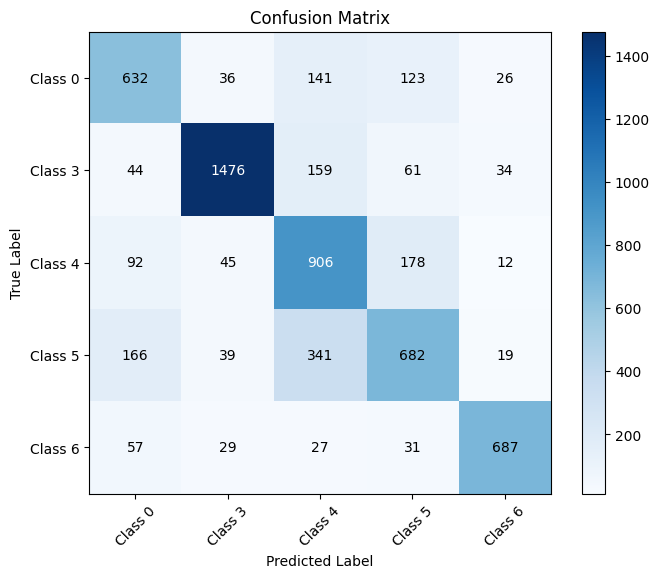

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.64      0.66      0.65       958
     Class 3       0.91      0.83      0.87      1774
     Class 4       0.58      0.73      0.65      1233
     Class 5       0.63      0.55      0.59      1247
     Class 6       0.88      0.83      0.85       831

    accuracy                           0.73      6043
   macro avg       0.73      0.72      0.72      6043
weighted avg       0.74      0.73      0.73      6043



In [29]:
y_pred = model5.predict(x_test_filtered)
# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
# Use the true labels directly (assuming they are not one-hot encoded)
y_true_labels = y_test_filtered
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the values in the cells
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=classes))


In [10]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('model5.h5')

# Define emotion labels
emotion_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Load the face detection classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open a connection to the webcam (usually 0 for built-in webcam)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for face detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray_frame[y:y+h, x:x+w]

        # Normalize the pixel values to be in the range [0, 1]
        normalized_face = face_roi / 255.0

        # Resize the face to match the input size of the model
        resized_face = cv2.resize(normalized_face, (48, 48))

        # Expand the dimensions to match the model's expected input shape
        input_data = np.expand_dims(resized_face, axis=0)

        # Make predictions
        predictions = model.predict(input_data)

        # Get the predicted class (mood)
        predicted_class = np.argmax(predictions)

        # Add debugging print statements
        #print("Predicted class:", predicted_class)
        #print("Number of labels:", len(emotion_labels))

        # Get the corresponding emotion label
        predicted_label = emotion_labels[predicted_class]

        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Display the predicted label on the frame
        cv2.putText(frame, f'Predicted Mood: {predicted_label}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow('Webcam Feed', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()




1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 132ms/step
